# Deu certo

Essa tentativa deu certo e estamos já ordenado as paradas encontradas no próprio filtro

Gerando assim o arquivo: linhas_e_paradas_ordenadas_sentido.csv

In [27]:
import pandas as pd
import geopandas as gpd
from shapely import wkt

# Ler os dados
paradas_onibus_df = pd.read_csv('paradas_onibus.csv')
linhas_df = pd.read_csv('Linhas.csv')

# Converter para GeoDataFrames
paradas_onibus_df['geometry'] = paradas_onibus_df['geo_ponto_rede_pto'].apply(wkt.loads)
linhas_df['geometry'] = linhas_df['geo_linhas_lin'].apply(wkt.loads)

gdf_paradas_onibus = gpd.GeoDataFrame(paradas_onibus_df, geometry='geometry')
gdf_linhas = gpd.GeoDataFrame(linhas_df, geometry='geometry')

# Criar buffers em torno das linhas (ajuste a distância conforme necessário)
gdf_linhas_buffer = gdf_linhas.copy()
gdf_linhas_buffer['geometry'] = gdf_linhas.buffer(10)  # Ajuste o valor do buffer conforme necessário

# Inicializar um dicionário para armazenar as linhas e suas paradas associadas
linhas_e_paradas = {}

# Limite de distância para considerar uma parada como "associada" a uma linha (em metros)
limite_distancia = 10  # Ajuste conforme necessário

# Loop para cada linha
for idx_line, line in gdf_linhas.iterrows():
    linha_id = f"{line['linha']}_{line['sentido']}"
    linhas_e_paradas[linha_id] = []
    
    # Loop para cada parada de ônibus
    for idx_stop, stop in gdf_paradas_onibus.iterrows():
        # Calcular a distância entre a parada e a linha
        distancia = line['geometry'].distance(stop['geometry'])
        
        # Se a distância for menor do que o limite, associar a parada à linha
        if distancia < limite_distancia:
            coords = list(stop['geometry'].coords)[0]
            # Calcular a "posição projetada" ao longo da linha para a ordenação
            position_along_line = line['geometry'].project(Point(coords))
            linhas_e_paradas[linha_id].append((coords, position_along_line))

    # Ordenar as paradas com base na "posição projetada"
    linhas_e_paradas[linha_id] = sorted(linhas_e_paradas[linha_id], key=lambda x: x[1])

# Converter o dicionário em um DataFrame
df_linhas_e_paradas = pd.DataFrame([(key, [coords for coords, _ in value]) for key, value in linhas_e_paradas.items()], columns=['Linha_Sentido', 'Paradas'])

# Salvar o DataFrame como um arquivo CSV
df_linhas_e_paradas.to_csv('linhas_e_paradas_ordenadas_sentido.csv', index=False)

/home/lucasfrazao/Documentos/02_RotaOnibus/.venv/lib/python3.10/site-packages/shapely/linear.py:90: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/home/lucasfrazao/Documentos/02_RotaOnibus/.venv/lib/python3.10/site-packages/shapely/measurement.py:74: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


# Gerando arquivo com linha unica

In [22]:
import pandas as pd
import geopandas as gpd
from shapely import wkt

# Ler os dados
paradas_onibus_df = pd.read_csv('paradas_onibus.csv')
linhas_df = pd.read_csv('Linhas.csv')

# Converter para GeoDataFrames
paradas_onibus_df['geometry'] = paradas_onibus_df['geo_ponto_rede_pto'].apply(wkt.loads)
linhas_df['geometry'] = linhas_df['geo_linhas_lin'].apply(wkt.loads)

gdf_paradas_onibus = gpd.GeoDataFrame(paradas_onibus_df, geometry='geometry')
gdf_linhas = gpd.GeoDataFrame(linhas_df, geometry='geometry')

# Inicializar um dicionário para armazenar as linhas e suas paradas associadas
linhas_e_paradas = {}

# Limite de distância para considerar uma parada como "associada" a uma linha (em metros)
limite_distancia = 20  # Ajuste conforme necessário

# Loop para cada linha
for idx_line, line in gdf_linhas.iterrows():
    # Usando somente o valor da coluna "linha" como identificador
    linha_id = f"{line['linha']}"
    
    if linha_id not in linhas_e_paradas:
        linhas_e_paradas[linha_id] = []
    
    # Loop para cada parada de ônibus
    for idx_stop, stop in gdf_paradas_onibus.iterrows():
        # Calcular a distância entre a parada e a linha
        distancia = line['geometry'].distance(stop['geometry'])
        
        # Se a distância for menor do que o limite, associar a parada à linha
        if distancia < limite_distancia:
            coords = list(stop['geometry'].coords)[0]
            # Calcular a "posição projetada" ao longo da linha para a ordenação
            position_along_line = line['geometry'].project(Point(coords))
            linhas_e_paradas[linha_id].append((coords, position_along_line))

    # Ordenar as paradas com base na "posição projetada"
    linhas_e_paradas[linha_id] = sorted(linhas_e_paradas[linha_id], key=lambda x: x[1])

# Converter o dicionário em um DataFrame
df_linhas_e_paradas = pd.DataFrame([(key, [coords for coords, _ in value]) for key, value in linhas_e_paradas.items()], columns=['Linha_Sentido', 'Paradas'])

# Salvar o DataFrame como um arquivo CSV
df_linhas_e_paradas.to_csv('linhas_e_paradas_ordenadas.csv', index=False)

/home/lucasfrazao/Documentos/02_RotaOnibus/.venv/lib/python3.10/site-packages/shapely/linear.py:90: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/home/lucasfrazao/Documentos/02_RotaOnibus/.venv/lib/python3.10/site-packages/shapely/measurement.py:74: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


# Gerando o folium com alguma linha de teste

Aqui pegamos uma linha no arquivo csv e plotamos suas paradas no folium

In [28]:
import folium
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Carregar o DataFrame salvo anteriormente
df_linhas_e_paradas = pd.read_csv('linhas_e_paradas_ordenadas_sentido.csv')

# Filtrar as paradas da linha 813.2 no sentido de "IDA"
linha_813_2_ida = df_linhas_e_paradas[df_linhas_e_paradas['Linha_Sentido'] == '813.2_IDA']['Paradas'].iloc[0]

# Convertendo a string para uma lista de tuplas
import ast
linha_813_2_ida = ast.literal_eval(linha_813_2_ida)

# Criar um GeoDataFrame temporário
gdf_temp = gpd.GeoDataFrame(
    {'geometry': [Point(xy) for xy in linha_813_2_ida]},
    crs="EPSG:31983"  # Substitua pelo CRS apropriado se for diferente
)

# Reprojetar para WGS 84
gdf_temp = gdf_temp.to_crs(epsg=4326)

# Inicializar o mapa do Folium (ajuste as coordenadas iniciais conforme necessário)
m = folium.Map(location=[-15.7942, -47.8825], zoom_start=12)

# Adicionar as paradas ao mapa
for point in gdf_temp['geometry']:
    coords = list(point.coords)[0]
    folium.Marker([coords[1], coords[0]]).add_to(m)

# Salvar ou mostrar o mapa
m.save('linha_813_2_ida_map.html')

# Grafo

Agora que já temos as paradas já oordenadas, fazemos um grafo com ela, de uma linha por exemplo.

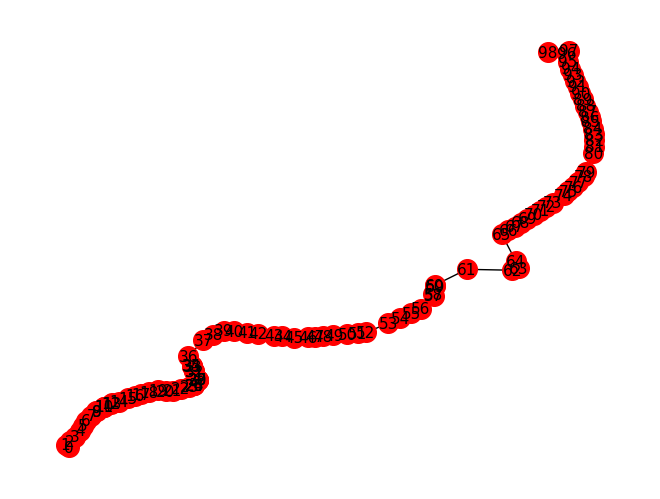

In [13]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import ast

# Carregar o DataFrame salvo anteriormente
df_linhas_e_paradas = pd.read_csv('linhas_e_paradas_ordenadas_sentido.csv')

# Filtrar as paradas da linha 813.2 no sentido de "IDA"
linha_813_2_ida = df_linhas_e_paradas[df_linhas_e_paradas['Linha_Sentido'] == '813.2_IDA']['Paradas'].iloc[0]

# Convertendo a string para uma lista de tuplas
linha_813_2_ida = ast.literal_eval(linha_813_2_ida)

# Criar um grafo usando NetworkX
G = nx.Graph()

# Adicionar vértices e arestas ao grafo
for i in range(len(linha_813_2_ida)):
    G.add_node(i, coords=linha_813_2_ida[i])
    if i > 0:
        G.add_edge(i-1, i)

# Plotar o grafo
pos = {i: coords for i, coords in enumerate(linha_813_2_ida)}
nx.draw(G, pos, with_labels=True, node_color='red', font_weight='0', node_size=200, font_size=11)
plt.show()

# Salvando grafo

Podemos salvar o grafo

In [41]:
import pandas as pd
import networkx as nx
import ast
import pickle

# Carregar o DataFrame salvo anteriormente
df_linhas_e_paradas = pd.read_csv('linhas_e_paradas_ordenadas_sentido.csv')

# Filtrar as paradas da linha 813.2 no sentido de "IDA"
linha_813_2_ida = df_linhas_e_paradas[df_linhas_e_paradas['Linha_Sentido'] == '813.2_IDA']['Paradas'].iloc[0]

# Convertendo a string para uma lista de tuplas
linha_813_2_ida = ast.literal_eval(linha_813_2_ida)

# Criar um grafo usando NetworkX
G = nx.Graph()

# Adicionar vértices e arestas ao grafo
for i in range(len(linha_813_2_ida)):
    G.add_node(i, coords=linha_813_2_ida[i])
    if i > 0:
        G.add_edge(i-1, i)

# Salvar o grafo em um arquivo
with open('grafo_813_2_Ida.grafo', 'wb') as f:
    pickle.dump(G, f)

# Carregando o grafo

In [21]:
import pickle

with open('grafo_813_2_Ida.grafo', 'rb') as f:
    G = pickle.load(f)

# Plotando o grafo

Podemos plotar o grafo já salvo

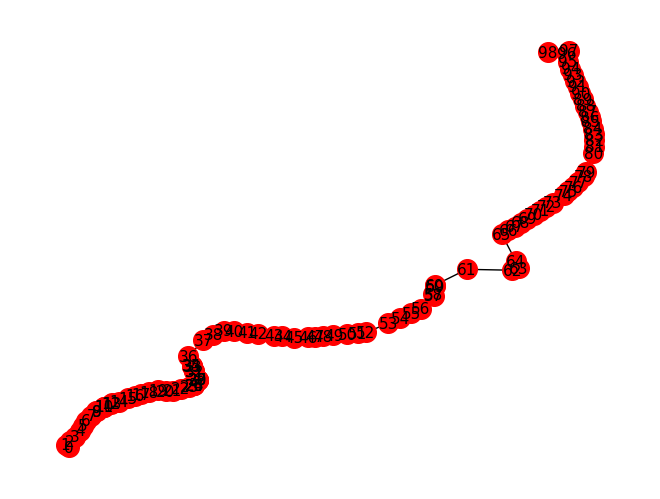

In [23]:
# Plotar o grafo
pos = {i: data['coords'] for i, data in G.nodes(data=True)}
nx.draw(G, pos, with_labels=True, node_color='red', font_weight='0', node_size=200, font_size=11)
plt.show()

# Plotando no folium

Agora, podemos plotar o grafo no folium, precisamos converter o sistema de coordenada.

In [27]:
import folium
import pickle
from pyproj import Transformer

# Inicializar o transformador de coordenadas
transformer = Transformer.from_crs("EPSG:31983", "EPSG:4326", always_xy=True)

# Ler o grafo de um arquivo usando pickle
with open('grafo_813_2_Ida.grafo', 'rb') as f:
    G = pickle.load(f)

# Inicializar o mapa do Folium (ajuste as coordenadas iniciais conforme necessário)
m = folium.Map(location=[-23.550520, -46.633308], zoom_start=12)  # Coordenadas de São Paulo como exemplo

# Adicionar as paradas ao mapa
for i, data in G.nodes(data=True):
    coords = data['coords']
    # Transformar as coordenadas para o sistema EPSG:4326
    transformed_coords = transformer.transform(coords[0], coords[1])
    folium.Marker([transformed_coords[1], transformed_coords[0]], popup=f'Ordem: {i}').add_to(m)

# Salvar ou mostrar o mapa
m.save('grafo_813_2_Ida_map.html')

# Várias rotas

Agora, iremos transformar várias rotas em um único grafo

In [34]:
import pandas as pd
import networkx as nx
import ast
import pickle

# Carregar o DataFrame salvo anteriormente
df_linhas_e_paradas = pd.read_csv('linhas_e_paradas_ordenadas_sentido.csv')

# Lista das linhas e sentidos para incluir no grafo
linhas_para_incluir = ['313.2_IDA', '0.018_IDA', '0.883_VOLTA']
cores = {'313.2_IDA': 'red', '0.018_IDA': 'green', '0.883_VOLTA': 'blue'}

# Criar um grafo usando NetworkX
G = nx.Graph()

# Contador de vértices
contador = 0

# Loop para adicionar vértices e arestas ao grafo
for linha in linhas_para_incluir:
    linha_data = df_linhas_e_paradas[df_linhas_e_paradas['Linha_Sentido'] == linha]['Paradas'].iloc[0]
    linha_data = ast.literal_eval(linha_data)
    
    primeiro_vertice = contador
    for i in range(len(linha_data)):
        G.add_node(contador, coords=linha_data[i], cor=cores[linha])
        if i > 0:
            G.add_edge(contador-1, contador, cor=cores[linha])
        contador += 1

# Salvar o grafo em um arquivo usando pickle
with open('grafo_multiplas_linhas.grafo', 'wb') as f:
    pickle.dump(G, f)

# Plotando

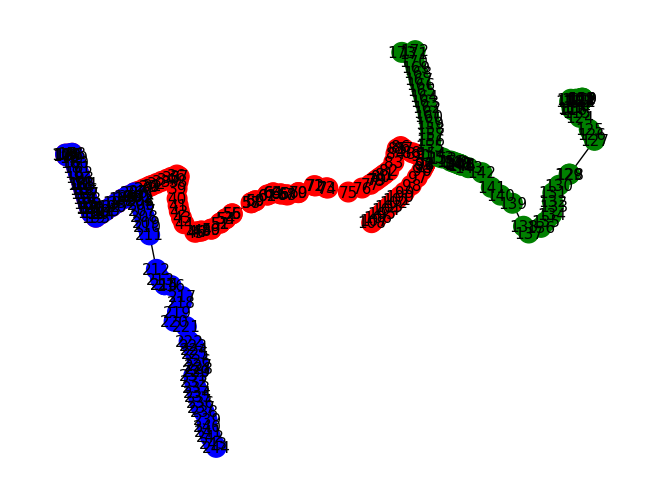

In [35]:
import networkx as nx
import matplotlib.pyplot as plt
import pickle

# Ler o grafo de um arquivo usando pickle
with open('grafo_multiplas_linhas.grafo', 'rb') as f:
    G = pickle.load(f)

# Plotar o grafo
pos = {i: data['coords'] for i, data in G.nodes(data=True)}
cores = [data['cor'] for _, data in G.nodes(data=True)]
nx.draw(G, pos, with_labels=True, node_color=cores, font_weight='0', node_size=200, font_size=11)
plt.show()

Em html

In [36]:
import folium
import pickle
from pyproj import Transformer

# Inicializar o transformador de coordenadas
transformer = Transformer.from_crs("EPSG:31983", "EPSG:4326", always_xy=True)

# Ler o grafo de um arquivo usando pickle
with open('grafo_multiplas_linhas.grafo', 'rb') as f:
    G = pickle.load(f)

# Inicializar o mapa do Folium (ajuste as coordenadas iniciais conforme necessário)
m = folium.Map(location=[-23.550520, -46.633308], zoom_start=12)  # Coordenadas de São Paulo como exemplo

# Adicionar as paradas e as rotas ao mapa
linhas = {}  # Dicionário para armazenar as coordenadas de cada linha
for i, j, data in G.edges(data=True):
    cor = data['cor']
    if cor not in linhas:
        linhas[cor] = []
    
    coords_i = G.nodes[i]['coords']
    coords_j = G.nodes[j]['coords']
    
    # Transformar as coordenadas para o sistema EPSG:4326
    coords_i_transformed = transformer.transform(coords_i[0], coords_i[1])
    coords_j_transformed = transformer.transform(coords_j[0], coords_j[1])
    
    linhas[cor].append([coords_i_transformed[::-1], coords_j_transformed[::-1]])

# Adicionar PolyLines ao mapa
for cor, coords in linhas.items():
    folium.PolyLine(coords, color=cor, weight=2.5, opacity=1).add_to(m)

# Adicionar os marcadores ao mapa
for i, data in G.nodes(data=True):
    coords = data['coords']
    cor = data['cor']
    
    # Transformar as coordenadas para o sistema EPSG:4326
    transformed_coords = transformer.transform(coords[0], coords[1])
    
    folium.Marker([transformed_coords[1], transformed_coords[0]], 
                  popup=f'Ordem: {i}', 
                  icon=folium.Icon(color=cor)).add_to(m)

# Salvar ou mostrar o mapa
m.save('grafo_multiplas_linhas_map.html')


Aplicando jitter para paradas de diferenstes linhas

In [39]:
import folium
import pickle
from pyproj import Transformer
import random

# Inicializar o transformador de coordenadas
transformer = Transformer.from_crs("EPSG:31983", "EPSG:4326", always_xy=True)

# Ler o grafo de um arquivo usando pickle
with open('grafo_multiplas_linhas.grafo', 'rb') as f:
    G = pickle.load(f)

# Inicializar o mapa do Folium (ajuste as coordenadas iniciais conforme necessário)
m = folium.Map(location=[-23.550520, -46.633308], zoom_start=12)  # Coordenadas de São Paulo como exemplo

# Adicionar as paradas e as rotas ao mapa
linhas = {}  # Dicionário para armazenar as coordenadas de cada linha
for i, j, data in G.edges(data=True):
    cor = data['cor']
    if cor not in linhas:
        linhas[cor] = []
    
    coords_i = G.nodes[i]['coords']
    coords_j = G.nodes[j]['coords']
    
    # Transformar as coordenadas para o sistema EPSG:4326
    coords_i_transformed = transformer.transform(coords_i[0], coords_i[1])
    coords_j_transformed = transformer.transform(coords_j[0], coords_j[1])
    
    linhas[cor].append([coords_i_transformed[::-1], coords_j_transformed[::-1]])

# Adicionar PolyLines ao mapa
for cor, coords in linhas.items():
    folium.PolyLine(coords, color=cor, weight=2.5, opacity=1).add_to(m)

# Jitter: um pequeno deslocamento aleatório para evitar sobreposição de marcadores
jitter = 0.0001  

# Adicionar os marcadores ao mapa
for i, data in G.nodes(data=True):
    coords = data['coords']
    cor = data['cor']
    
    # Transformar as coordenadas para o sistema EPSG:4326
    transformed_coords = transformer.transform(coords[0], coords[1])
    
    # Adicionar jitter
    lat_jitter = random.uniform(-jitter, jitter)
    lon_jitter = random.uniform(-jitter, jitter)
    
    folium.Marker([transformed_coords[1] + lat_jitter, transformed_coords[0] + lon_jitter], 
                  popup=f'Ordem: {i}', 
                  icon=folium.Icon(color=cor)).add_to(m)

# Salvar ou mostrar o mapa
m.save('grafo_jitter_multiplas_linhas_map.html')
